In [1]:
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

from dataset import get_dataset_class_number
from dataset import get_num_samples
from utils import *

plt.style.use(['science', 'grid'])
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 11})


In [2]:
def parse_tensorboard(path, scalar_name):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert scalar_name in ea.Tags()["scalars"]
    return ea.Scalars(scalar_name)


def read_data(data_path):
    results = []
    for name in os.listdir(data_path):
        path = os.path.join(data_path, name)
        if not os.path.isdir(path):
            continue
        if not os.path.isfile(os.path.join(path, 'results.json')):
            continue
        with open(os.path.join(path, 'results.json'), 'r') as f:
            res = json.load(f)
        with open(os.path.join(path, 'args.json'), 'r') as f:
            args = json.load(f)
            if args['method'] not in methods:
                continue
        test_error_curve = {'test_error_curve': [(100 - v.value) for v in parse_tensorboard(path, 'Accuracy1/test')]}
        dic = res | args | test_error_curve
        # dic['path'] = path
        results.append(dic)
    df = pd.DataFrame(results)
    # df = df.loc[(df['vf_bound'] != -inf)]
    df = df[['S_seed', 'seed', 'method', 'test_acc', 'num_samples', 'ghost_dataset_name', 'test_error_curve']]
    df['test_error'] = 100 - df['test_acc']
    df = df.loc[(df['ghost_dataset_name'].isnull())]
    return df


def get_exp_res_dict(df):
    exp_res_dict = {
        method: {k: None for k in num_samples} for method in methods
    }
    for method in methods:
        for ns in num_samples:
            df_exp = df.loc[(df['method'] == method) & (df['num_samples'] == ns)]
            curve = pd.DataFrame(df_exp['test_error_curve'].values.tolist()) * 0.01
            avg_test_curve = (curve.mean(0), curve.std(0))
            exp_res_dict[method][ns] = avg_test_curve
    return exp_res_dict


In [3]:
num_seeds = 5
num_S_seeds = 5
datasets = ('cifar10', 'svhn', 'stl10', 'fashion')
datasets_name = ('CIFAR10', 'SVHN', 'STL10', 'Fashion')
methods = ['vanilla', 'rib_minimax', 'rib']

all_exp_res_dicts = {}

for dataset in datasets:  # ('mnist','fashion', 'cifar10', 'svhn', 'stl10'):
    data_path = f'<your data dir>/train_my_cnn.CNN_my_mlp.MLP_seed_5_5_nh3/{dataset}/'
    num_classes = get_dataset_class_number(dataset)
    num_samples = get_num_samples(dataset)
    df = read_data(data_path)

    exp_res_dicts = get_exp_res_dict(df)
    all_exp_res_dicts[dataset] = exp_res_dicts


def plot(dataset, ns, ax):
    for i, method in enumerate(methods):
        mean = all_exp_res_dicts[dataset][method][ns][0].to_numpy()[:epochs]
        std = all_exp_res_dicts[dataset][method][ns][1].to_numpy()[:epochs]
        ax.plot(range(epochs), mean, label=methods_name[i], lw=1.5)
        ax.fill_between(range(epochs), mean - std, mean + std, alpha=0.2)
        # ax.set_xticks([0, 40, 80])
        ax.tick_params(labelsize=16)


In [4]:
markers = ['o', '^', 's']
save_path = '<your data dir>/train_my_cnn.CNN_my_mlp.MLP_seed_5_5_nh3/'
methods_name = ['SGD', 'RIB-adv', 'RIB']


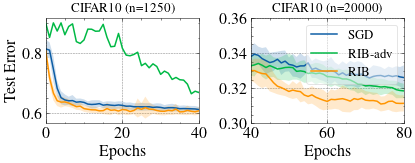

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
epochs = 81

dataset = 'cifar10'
plot(dataset, 1250, axes[0])
plot(dataset, 20000, axes[1])

axes[0].set_ylabel('Test Error', size=16)
axes[0].set_xlabel('Epochs', size=16)
axes[1].set_xlabel('Epochs', size=16)
axes[1].legend(loc='upper right', fontsize=13).get_frame().set_alpha(0.5)
# ax1][1].legend(fontsize=15)
axes[0].set_xlim(0, 40)
axes[1].set_xlim(40, 80)
axes[1].set_ylim(0.3, 0.36)

axes[0].title.set_text("CIFAR10 (n=1250)")
axes[1].title.set_text("CIFAR10 (n=20000)")

fig.tight_layout()
fig.savefig(os.path.join(save_path + f'cifar10_loss_curve.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

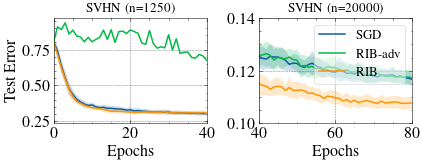

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
epochs = 81

dataset = 'svhn'
plot(dataset, 1250, axes[0])
plot(dataset, 20000, axes[1])

axes[0].set_ylabel('Test Error', size=16)
axes[0].set_xlabel('Epochs', size=16)
axes[1].set_xlabel('Epochs', size=16)
axes[1].legend(loc='upper right', fontsize=13).get_frame().set_alpha(0.5)
# ax1][1].legend(fontsize=15)
axes[0].set_xlim(0, 40)
axes[1].set_xlim(40, 80)
axes[1].set_ylim(0.1, 0.14)

axes[0].title.set_text("SVHN (n=1250)")
axes[1].title.set_text("SVHN (n=20000)")

fig.tight_layout()
fig.savefig(os.path.join(save_path + f'svhn_loss_curve.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()